# Code for profiling paper

link to presentation:

 https://docs.google.com/presentation/d/1RXceHE59gw2YfzfJZhaElSRb3rIPDr-1/edit?usp=sharing&ouid=103705832009765615891&rtpof=true&sd=true

## In this paper we profile sparql logs of bio2rdf and wikidata and collect representative queries.

Method:

- delete http parameters such as &format ,...
- get unique queries (does not handle the white spaces)
- add prefixes
- parse queries
- get normalized queries
- get unique queries from normalized verion and parsed tree(to handle white space problem)
- profile table: Keyword count in queries
(SELECT, Ask, Describe, Construct, Distinct, Limit, Offset, Order By, Filter, And, Union, Opt, Graph, Not Exists, Minus, Exists, Count, Max, Min, Avg, Sum, Group By, Having)
- calculate informativness,
- get distributaion of triple patterns
- cluster queries based on their similarity
- define semantic metrics


Next steps:

1. read all papers in logs analysis at once to get the scope of my paper
2. write scope of paper and share with supervisers 
3. document all results with in a table 
4- think of changing terms to correct one 
5. analyse results
6. have some changes and take initiative in defining metrics and defining a method to find representative




## 1. We download the query logs that Vincent is provided at dumontior Lab website. 
link to download the logs: https://download.dumontierlab.com/bio2rdf/logs/

The logs are stored in a file with name "bio2rdf_sparql_logs_processed_01-2019_to_07-2021.csv"

## Number of queries are 3880939

In [ ]:
import pandas as pd

df = pd.read_csv('data//bio2rdf_sparql_logs_processed_01-2019_to_07-2021.csv', lineterminator='\n', dtype=str, encoding='utf-8')

# Count the number of null values in each column
null_counts = df.isnull().sum()

print("Null value counts:")
print(null_counts)
print(len(df))
pd.set_option('display.max_colwidth', None)  # Display full content of columns
print(df.head())

following code is for counting SPARQL keywords such as select, filter,etc.

In [42]:
import csv
import re
from collections import defaultdict

# Define the keywords to count (in lowercase)
keywords_to_count = [
    "select",
    "ask",
    "describe",
    "construct",
    "distinct",
    "limit",
    "offset",
    "order by",
    "filter",
    "and",
    "union",
    "optional",
    "graph",
    "not exists",
    "minus",
    "exists",
    "count",
    "max",
    "min",
    "avg",
    "sum",
    "group by",
    "having"
]

# Function to count keywords in a query (case-insensitive)
def count_keywords(query):
    keyword_count = defaultdict(int)
    
    for keyword in keywords_to_count:
        # Use re.IGNORECASE flag for case-insensitive search
        keyword_count[keyword] += len(re.findall(rf"\b{re.escape(keyword)}\b", query, flags=re.IGNORECASE))
    
    return keyword_count

# Input and output file paths
input_file = "bio2rdf_sparql_logs_processed_01-2019_to_07-2021.csv"
output_file = "keywords_count.csv"

# Initialize a dictionary to store the overall keyword counts
overall_keyword_count = defaultdict(int)

# Process the input and accumulate keyword counts for the "query" column
with open(input_file, "r", newline="", encoding="utf-8") as infile:
    reader = csv.DictReader(infile)
            # Remove null characters from the input
    content = infile.read().replace('\x00', '')

        # Split content into lines and process each line
    lines = content.splitlines()

        # Read the first line as header to get field names
    reader = csv.DictReader(lines)
    fieldnames = reader.fieldnames

    for row in reader:
        if "query" in row and row["query"]:
            query = row["query"]
            keyword_count = count_keywords(query)
            for keyword, count in keyword_count.items():
                overall_keyword_count[keyword] += count

# Write the overall keyword counts to the output file
with open(output_file, "w", newline="", encoding="utf-8") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["Keyword", "Count"])  # Header row
    for keyword, count in overall_keyword_count.items():
        writer.writerow([keyword, count])

print("Overall keyword count complete. Results saved to", output_file)


Overall keyword count complete. Results saved to keywords_count.csv


## 2. We remove all queries from the part starts with any of these keywords:

keywords = ["&format", "&timeout", "&debug", "&run", "&maxrows", "&infer", "&output", "&results", "&default-graph-uri"]

later I found that number of queries having parse error because of having following:

 ";format", "&amp" ";timeout" , ";debug" , "&callback" 

 note: 

**Help! Why number of queries increased to 3880960 after removing those keywords? what is the bug?**

In [43]:
import csv
import re

def remove_keywords(query):
    # List of keywords to remove
    keywords = ["&format", "&timeout", "&debug", "&run",
                "&maxrows", "&infer", "&output", "&results",
                "&default-graph-uri", ";format", "&amp" ";timeout" , ";debug" , "&callback"]

    # Regular expression to find any of the keywords in the query
    regex = '|'.join(re.escape(keyword) for keyword in keywords)

    # Remove the matched part of the query and everything after it
    query = re.sub(rf'({regex}).*', '', query)

    return query.strip()

def process_csv(input_file, output_file):
    with open(input_file, 'r', newline='\n', encoding='utf-8') as infile, \
            open(output_file, 'w', newline='\n', encoding='utf-8') as outfile:
        # Remove null characters from the input
        content = infile.read().replace('\x00', '')

        # Split content into lines and process each line
        lines = content.splitlines()

        # Read the first line as header to get field names
        reader = csv.DictReader(lines)
        fieldnames = reader.fieldnames

        writer = csv.DictWriter(outfile, fieldnames=fieldnames, lineterminator='\n')
        writer.writeheader()

        for row in reader:
            row['query'] = remove_keywords(row['query'])
            writer.writerow(row)

if __name__ == "__main__":
    input_csv_file = "bio2rdf_sparql_logs_processed_01-2019_to_07-2021.csv"
    output_csv_file = "new_removedformats_bio2rdf_logs.csv"
    process_csv(input_csv_file, output_csv_file)
    print('done')

done


In [44]:
import pandas as pd

df = pd.read_csv('new_removedformats_bio2rdf_logs.csv', lineterminator='\n', dtype=str)

print(len(df))

print(df.head())

3880960
                                               query       domain  \
0  CONSTRUCT { ?s ?p ?o . } WHERE { SERVICE <http...  bio2rdf.org   
1  SELECT DISTINCT ?prefix WHERE { { SELECT DISTI...  bio2rdf.org   
2           select * where {[] a ?Concept} LIMIT 100  bio2rdf.org   
3  With the advantages of utilizing a job recruit...  bio2rdf.org   
4  With the advantages of utilizing a job recruit...  bio2rdf.org   

                                               agent                 timestamp  
0  Umaka-Crawler/1.0.0 by DBCLS (umakadata@dbcls.jp)  2020-03-11T06:13:19.227Z  
1  Umaka-Crawler/1.0.0 by DBCLS (umakadata@dbcls.jp)  2020-03-11T06:18:36.078Z  
2  Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...  2020-03-11T13:48:04.625Z  
3  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...  2021-04-20T10:18:11.078Z  
4  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...  2021-04-20T10:18:11.132Z  


## 3. We extract unique queries and their count

Note: this code dose not handle whitespaces to identify unique queries. after parsing queries I use parse tree to identify unique queries. current step is only for optimizing query parsing process.

In [2]:
import csv

def extract_unique_queries(input_file, output_file):
    try:
        # Initialize a dictionary to store query counts
        query_counts = {}

        with open(input_file, 'r', newline='\n', encoding='utf-8') as infile:
            reader = csv.DictReader(infile)

            # Iterate through the rows and count queries
            for row in reader:
                query = row['query']  # Assuming 'query' is the correct column name
                query_counts[query] = query_counts.get(query, 0) + 1

        # Sort queries and their counts based on the count column in descending order
        sorted_queries = sorted(query_counts.items(), key=lambda item: item[1], reverse=True)

        # Write sorted queries and their counts to the output CSV file
        with open(output_file, 'w', newline='\n', encoding='utf-8') as outfile:
            writer = csv.writer(outfile, lineterminator='\n')
            writer.writerow(['query', 'count'])  # Write header

            for query, count in sorted_queries:
                writer.writerow([query, count])

        print("Unique queries extracted with counts and written to", output_file)

    except FileNotFoundError:
        print("Error: Input CSV file not found.")
    except Exception as e:
        print("An error occurred:", e)

# Replace 'input_file.csv' with the name of your CSV file and 'output_file.csv' with the desired output filename
extract_unique_queries('new_removedformats_bio2rdf_logs.csv', 'new_unique_bio2rdf_sparql_logs_with_counts.csv')


Unique queries extracted with counts and written to new_unique_bio2rdf_sparql_logs_with_counts.csv


In [3]:
import pandas as pd

df = pd.read_csv('new_unique_bio2rdf_sparql_logs_with_counts.csv', lineterminator='\n', dtype=str)

print(len(df))
df.head(30)

1051679


,query,count
0,ASKWHERE { ?s ?p ?o},539922
1,SELECT ?sWHERE { ?s ?p ?o}LIMIT 1,365078
2,SELECT ?tWHERE { ?x ?y ?t }LIMIT 1,244841
3,ASKWHERE { ?s ?p ?o },83599
4,SELECT (COUNT(?c) AS ?x)WHERE { ?s <http://w...,44671
5,SELECT (COUNT(?p) AS ?x)WHERE { ?s ?p ?o},44662
6,SELECT ?s WHERE { ?s ?p ?o } LIMIT 1,35443
7,ASK WHERE { ?s ?p ?o },35441
8,SELECT *WHERE { ?s ?p ?o}LIMIT 1,13762
9,SELECT *WHERE { ?s ?p ?o}LIMIT 100002,13701


## 4. Parse the queries:  



- download Node.js from the official website: https://nodejs.org/

- Installed Node js 

- npm install sparqljs


In [ ]:

!npm install csv-parser


In [ ]:
!npm install csv-stringify

In [ ]:
# create a python file with following content(mine is called "optimized_from_js_.py")

import subprocess

def run_script():
    # Run the JavaScript code using Node.js as a subprocess
    result = subprocess.run(['node', 'optimized.js'], stdout=subprocess.PIPE, text=True)

    # Print the output (JSON representation of the parsed SPARQL query)
    print(result.stdout)
    print('hi')

if __name__ == "__main__":
    run_script()


In [ ]:
#  In Unix-like operating systems
!nohup python optimized_from_js_.py 

In [ ]:
# In windows
!pythonw optimized_from_js_.py > output90.txt


In [1]:
import pandas as pd

column_names = ['query', 'parsed_query']

df = pd.read_csv('new_parsed.csv', lineterminator='\n', dtype=str, header=None, names=column_names)

print(len(df))
df.head(10)

1051679


,query,parsed_query
0,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri..."
1,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""termType""..."
2,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""termType""..."
3,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri..."
4,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""expressio..."
5,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""expressio..."
6,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""termType""..."
7,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri..."
8,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{}],""where""..."
9,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{}],""where""..."


## Following code returns valid queries and their parsed tree(removes unvalid):

In [8]:
import csv

# Define the input and output file paths
input_file_path = 'new_parsed.csv'
output_file_path = 'valid_parsed.csv'

# Open the input CSV file for reading
with open(input_file_path, 'r', newline='\n', encoding='utf-8') as input_file:
    # Create a CSV reader without header
    reader = csv.reader(input_file)
    
    # Create a list to store valid rows
    valid_rows = []
    
    for row in reader:
        # Check if the second column is not equal to 'Error parsing the query'
        if len(row) >= 2 and row[1] != 'Error parsing the query.':
            valid_rows.append(row)

# Open the output CSV file for writing
with open(output_file_path, 'w', newline='\n', encoding='utf-8') as output_file:
    # Create a CSV writer with column names
    writer = csv.writer(output_file)
    
    # Write column names
    writer.writerow(['query', 'parsed_query'])
    
    # Write the valid rows
    writer.writerows(valid_rows)

print(f"Valid rows have been written to '{output_file_path}'.")


Valid rows have been written to 'valid_parsed.csv'.


In [10]:
import pandas as pd

# column_names = ['query', 'parsed_query']

df = pd.read_csv('valid_parsed.csv', lineterminator='\n', dtype=str)

print(len(df))
df.head(10)

634783


,query,parsed_query\r
0,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri..."
1,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""termType""..."
2,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""termType""..."
3,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri..."
4,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""expressio..."
5,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""expressio..."
6,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{""termType""..."
7,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri..."
8,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{}],""where""..."
9,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,"{""queryType"":""SELECT"",""variables"":[{}],""where""..."


In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('valid_parsed.csv', lineterminator='\n', dtype=str)

# Count unique values in the "ColumnName" column
unique_count = df['parsed_query\r'].nunique()

print(f"Number of unique values in the 'parsed_query' column: {unique_count}")


Number of unique values in the 'parsed_query' column: 633453


In [4]:
import pandas as pd

column_names = ['query', 'parsed_query']
# Read the CSV file with the "query" and "parsed_query" columns
df = pd.read_csv('valid_parsed.csv', lineterminator='\n', dtype=str, names=column_names)

# Group the DataFrame by the "parsed_query" column and collect the corresponding "query" values into a list
grouped = df.groupby('parsed_query')['query'].apply(list).reset_index()

# Create a list to store rows of the final DataFrame
output_rows = []

# Iterate through the grouped DataFrame and choose one query for each unique parsed query
for _, row in grouped.iterrows():
    parsed_query = row['parsed_query']
    queries = row['query']
    chosen_query = queries[0]  # Choose the first query for each unique parsed query
    output_rows.append({'parsed_query': parsed_query, 'query': chosen_query})

# Create the final DataFrame from the list of rows
output_df = pd.DataFrame(output_rows, columns=['parsed_query', 'query'])

# Save the output DataFrame to a new CSV file
output_file = 'unique_valid_11_9_2023.csv'
output_df.to_csv(output_file, index=False, header=False, lineterminator='\n')



In [5]:
import pandas as pd

df = pd.read_csv('unique_valid_11_9_2023.csv', lineterminator='\n', dtype=str)

print(len(df))
df.head(10)

633453


,parsed_query\r,query
0,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
1,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
2,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
3,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
4,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
5,"{""queryType"":""ASK"",""where"":[],""type"":""query"",""...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
6,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
7,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
8,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
9,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...


## After adding prefixes: We have 8,176 more queries parsed.
Number of failures: 419420

Number of queries parsed: 632,258

In [ ]:
import pandas as pd

df = pd.read_csv('my-sparql-project//prefix_parsed_queries_all.csv', lineterminator='\n', dtype=str)

# Count the number of null values in each column
null_counts = df.isnull().sum()

print("Null value counts:")
print(null_counts)
print(len(df))
pd.set_option('display.max_colwidth', None)  # Display full content of columns
print(df.head())

Null value counts:
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX owl: <http://www.w3.org/2002/07/owl#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX dcterms: <http://purl.org/dc/terms/>\nPREFIX skos: <http://www.w3.org/2004/02/skos/core#>\nPREFIX schema: <http://schema.org/>\nPREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>\n\nASKWHERE  { ?s ?p ?o}                                                                                                                                        0
{"queryType":"ASK","where":[{"type":"bgp","triples":[{"subject":{"termType":"Variable","value":"s"},"predicate":{"termType":"Variable","value":"p"},"object":{"termType":"Variable","value":"o"}}]}],"type":"query","prefixes":{"rdf":"http://www.w3.org/1999/02/22-rdf-syntax-ns#","rdfs":"http://www.w3.org/2000/01/rdf-schema#","owl":"h

## 5. We add following list of prefixes to all queries:

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX owl: <http://www.w3.org/2002/07/owl#>

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX foaf: <http://xmlns.com/foaf/0.1/>

PREFIX dc: <http://purl.org/dc/elements/1.1/>

PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

PREFIX schema: <http://schema.org/>

PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>


In [4]:
import pandas as pd

def add_prefix(query):
    # The common prefix to add to each query
    prefix = """PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX schema: <http://schema.org/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

"""
    return prefix + query

def add_prefix_to_csv(input_file, output_file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(input_file)

    # Add the prefix to the "query" column using the add_prefix function
    df['query'] = df['query'].apply(add_prefix)

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_file, index=False)

if __name__ == "__main__":
    input_csv_file = "new_unique_bio2rdf_sparql_logs_with_counts.csv"  # Replace with the path to your input CSV file
    output_csv_file = "prefixes_added_bio2rdf.csv"  # Replace with the path to your output CSV file
    add_prefix_to_csv(input_csv_file, output_csv_file)
    print('Done!')

Done!


In [5]:
import pandas as pd
df = pd.read_csv('prefixes_added_bio2rdf.csv', lineterminator='\n', dtype=str)

# Count the number of null values in each column
null_counts = df.isnull().sum()

print("Null value counts:")
print(null_counts)
print(len(df))
pd.set_option('display.max_colwidth', None)  # Display full content of columns
print(df.head())

Null value counts:
query      0
count\r    0
dtype: int64
1051679
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   query  \
0                                                                       PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX owl: <http://www.w3.org/2002/07/owl#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX dc: <http://purl

## Query normalization

step1: variation

In [11]:
import re
import csv

def normalize_query(query, variable_mapping):
    for old_var, new_var in variable_mapping.items():
        query = query.replace(old_var, new_var)
    return query

def main():
    input_csv_file = "unique_valid_11_9_2023.csv"
    output_csv_file = "normalised_step1.csv"
    
    with open(input_csv_file, "rU", newline="", encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        rows = list(reader)
    
    normalized_queries = []
    for row in rows:
        if len(row) >= 2:  # Check if the row has at least two columns
            original_query = row[0]  # Original data from the first column
            query = row[1]  # Use 'query' column (second column)
            variables = re.findall(r'\?[a-zA-Z]+', query)
        
            variable_mapping = {}  # Mapping for each query
            variable_counter = 1
            for var in variables:
                if var not in variable_mapping:
                    variable_mapping[var] = f"?var{variable_counter}"
                    variable_counter += 1
        
            normalized_query = normalize_query(query, variable_mapping)
            normalized_queries.append([original_query, normalized_query])
        else:
            print(f"Skipping row: {row}")

    # Specify 'utf-8' encoding when writing the output CSV file
    with open(output_csv_file, "w", newline="\n", encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(normalized_queries)

if __name__ == "__main__":
    main()
    print('done')


C:\Users\p70073484\AppData\Local\Temp\ipykernel_8392\892019552.py:13: DeprecationWarning: 'U' mode is deprecated
  with open(input_csv_file, "rU", newline="", encoding='utf-8') as csvfile:


Skipping row: ['parsed_query']
done


In [1]:
import pandas as pd

df = pd.read_csv('unique_valid_11_9_2023.csv', lineterminator='\n', dtype=str)

print(len(df))
df.head(10)
df.info()

633453
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633453 entries, 0 to 633452
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
  633453 non-null  object
 1   query          633453 non-null  object
dtypes: object(2)
memory usage: 9.7+ MB


Step 2: remove the part starting from :

ORDER BY
LIMIT
OFFSET
DISTINCT
REDUCED
GROUP BY
HAVING

In [2]:
import csv
import re

# Define the keywords to remove (in lowercase)
keywords_to_remove = ["limit","offset"]

# Function to remove content after a keyword (case-insensitive)
def remove_content_after_keyword(query):
    for keyword in keywords_to_remove:
        # Use re.IGNORECASE flag for case-insensitive search
        query = re.sub(rf"{re.escape(keyword)}.*", "", query, flags=re.IGNORECASE)
    return query.strip()

# Input and output file paths
input_file = "normalised_step1.csv"
output_file = "normalised_step2.csv"

# Process the input and write to the output
with open(input_file, "r", newline="\n", encoding="utf-8") as infile, \
     open(output_file, "w", newline="\n", encoding="utf-8") as outfile:
    # Create CSV reader and writer objects
    reader = csv.DictReader(infile)
    fieldnames = ["query"]  # Specify the columns you want in the output
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    # Process each row and write to the output
    for row in reader:
        # Remove content after keywords from the "query" column (case-insensitive)
        row["query"] = remove_content_after_keyword(row["query"])
        # Write only the desired columns to the output
        output_row = {"query": row["query"]}
        writer.writerow(output_row)

print("Processing complete. Results saved to", output_file)


Processing complete. Results saved to normalised_step2.csv


In [4]:
import csv
import re

# Define the keywords to remove (in lowercase)
keywords_to_remove = ["limit", "offset"]

# Function to remove content after a keyword (case-insensitive)
def remove_content_after_keyword(query):
    for keyword in keywords_to_remove:
        # Use re.IGNORECASE flag for case-insensitive search
        query = re.sub(rf"{re.escape(keyword)}.*", "", query, flags=re.IGNORECASE)
    return query.strip()

# Input and output file paths
input_file = "normalised_step1.csv"
output_file = "normalised_step2.csv"

# Process the input and write to the output
with open(input_file, "r", newline="\n", encoding="utf-8") as infile, \
     open(output_file, "w", newline="\n", encoding="utf-8") as outfile:
    # Create CSV reader and writer objects
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames  # Get the fieldnames from the input
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    # Process each row and write to the output
    for row in reader:
        # Remove content after keywords from the "query" column (case-insensitive)
        row["query"] = remove_content_after_keyword(row["query"])
        # Write the row with modified "query" column to the output
        writer.writerow(row)

print("Processing complete. Results saved to", output_file)


Processing complete. Results saved to normalised_step2.csv


In [5]:
import pandas as pd

df = pd.read_csv('normalised_step2.csv', lineterminator='\n', dtype=str)

print(len(df))
df.head(10)

633453


,Unnamed: 0,query\r
0,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
1,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
2,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
3,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
4,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
5,"{""queryType"":""ASK"",""where"":[],""type"":""query"",""...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
6,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
7,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
8,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...
9,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""tri...",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...


In [6]:
import pandas as pd

column_names = ['parsed_query','query' ]
# Read the CSV file with the "query" and "parsed_query" columns
df = pd.read_csv('normalised_step2.csv', lineterminator='\n', dtype=str, names=column_names)

# Group the DataFrame by the "parsed_query" column and collect the corresponding "query" values into a list
grouped = df.groupby('query')['parsed_query'].apply(list).reset_index()

# Create a list to store rows of the final DataFrame
output_rows = []

# Iterate through the grouped DataFrame and choose one query for each unique parsed query
for _, row in grouped.iterrows():
    parsed_query = row['query']
    queries = row['parsed_query']
    chosen_query = queries[0]  # Choose the first query for each unique parsed query
    output_rows.append({'query': parsed_query, 'parsed_query': chosen_query})

# Create the final DataFrame from the list of rows
output_df = pd.DataFrame(output_rows, columns=['parsed_query','query' ])

# Save the output DataFrame to a new CSV file
output_file = 'unique_normalised_12_9_2023.csv'
output_df.to_csv(output_file, index=False, header=False, lineterminator='\n')

In [8]:
import pandas as pd

# Set the maximum column width to None to display the entire content of each cell
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('unique_normalised_12_9_2023.csv', lineterminator='\n', dtype=str, header=None)

print(len(df))
df.head(10)


545046


,0,1
0,"{""prefixes"":{""rdf"":""http://www.w3.org/1999/02/22-rdf-syntax-ns#"",""rdfs"":""http://www.w3.org/2000/01/rdf-schema#"",""owl"":""http://www.w3.org/2002/07/owl#"",""xsd"":""http://www.w3.org/2001/XMLSchema#"",""foaf"":""http://xmlns.com/foaf/0.1/"",""dc"":""http://purl.org/dc/elements/1.1/"",""dcterms"":""http://purl.org/dc/terms/"",""skos"":""http://www.w3.org/2004/02/skos/core#"",""schema"":""http://schema.org/"",""geo"":""http://www.w3.org/2003/01/geo/wgs84_pos#""}}\r",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX owl: <http://www.w3.org/2002/07/owl#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX dcterms: <http://purl.org/dc/terms/>\nPREFIX skos: <http://www.w3.org/2004/02/skos/core#>\nPREFIX schema: <http://schema.org/>\nPREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>\n\n# select * where {[] a ?var1}\r
1,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""triples"":[{""subject"":{""termType"":""NamedNode"",""value"":""http://nonsensical.com/6""},""predicate"":{""termType"":""Variable"",""value"":""p""},""object"":{""termType"":""NamedNode"",""value"":""http://nonsensical.com/7""}}]}],""type"":""query"",""prefixes"":{""rdf"":""http://www.w3.org/1999/02/22-rdf-syntax-ns#"",""rdfs"":""http://www.w3.org/2000/01/rdf-schema#"",""owl"":""http://www.w3.org/2002/07/owl#"",""xsd"":""http://www.w3.org/2001/XMLSchema#"",""foaf"":""http://xmlns.com/foaf/0.1/"",""dc"":""http://purl.org/dc/elements/1.1/"",""dcterms"":""http://purl.org/dc/terms/"",""skos"":""http://www.w3.org/2004/02/skos/core#"",""schema"":""http://schema.org/"",""geo"":""http://www.w3.org/2003/01/geo/wgs84_pos#""}}\r",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX owl: <http://www.w3.org/2002/07/owl#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX dcterms: <http://purl.org/dc/terms/>\nPREFIX skos: <http://www.w3.org/2004/02/skos/core#>\nPREFIX schema: <http://schema.org/>\nPREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>\n\nASK WHERE { <http://nonsensical.com/6> ?var1 <http://nonsensical.com/7> }\r
2,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""triples"":[{""subject"":{""termType"":""Variable"",""value"":""S""},""predicate"":{""termType"":""Variable"",""value"":""P""},""object"":{""termType"":""Variable"",""value"":""O""}}]}],""type"":""query"",""prefixes"":{""rdf"":""http://www.w3.org/1999/02/22-rdf-syntax-ns#"",""rdfs"":""http://www.w3.org/2000/01/rdf-schema#"",""owl"":""http://www.w3.org/2002/07/owl#"",""xsd"":""http://www.w3.org/2001/XMLSchema#"",""foaf"":""http://xmlns.com/foaf/0.1/"",""dc"":""http://purl.org/dc/elements/1.1/"",""dcterms"":""http://purl.org/dc/terms/"",""skos"":""http://www.w3.org/2004/02/skos/core#"",""schema"":""http://schema.org/"",""geo"":""http://www.w3.org/2003/01/geo/wgs84_pos#""}}\r",PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX owl: <http://www.w3.org/2002/07/owl#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX dcterms: <http://purl.org/dc/terms/>\nPREFIX skos: <http://www.w3.org/2004/02/skos/core#>\nPREFIX schema: <http://schema.org/>\nPREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>\n\nASK WHERE {?var1 ?var2 ?var3 .}\r
3,"{""queryType"":""ASK"",""where"":[{""type"":""bgp"",""triples"":[{""subject"":{""termType"":""Variable"",""value"":""x""},""predicate"":{""termType"":""NamedNode"",""value"":""http://www.w3.org/1999/02/22-rdf-syntax-ns#type""},""object"":{""termType"":""Variable"",""value"":""class""}}]}],""limit"":100,""type"":""query"",""prefixes"":{""rdf"":""http://www.w3.org/1999

##  We count subjects appearing in triple patterns of parsed queries, to calculate complexity

In [7]:
import pandas as pd
import re
import numpy as np

def count_subjects(parsed_query):
    if isinstance(parsed_query, str):
        return parsed_query.count("subject")
    else:
        return 0  # Return 0 for non-string values (e.g., NaN or float)

# Read the input CSV file
input_csv = 'unique_normalised_12_9_2023.csv'
df = pd.read_csv(input_csv)  # Assuming there is a header in the CSV

# Add or update the 'triple_pattern_number' column with the count of subjects
df['triple_pattern_number'] = df['parsed_query'].apply(count_subjects)

# Save the updated DataFrame back to the input CSV file, replacing the existing file
df.to_csv(input_csv, index=False)

print(f"Subject counts have been updated in the {input_csv} file.")


Subject counts have been updated in the unique_normalised_12_9_2023.csv file.


In [8]:
import pandas as pd

df = pd.read_csv('unique_normalised_12_9_2023.csv', lineterminator='\n', dtype=str)

# Count the number of null values in each column
null_counts = df.isnull().sum()


print(len(df))
pd.set_option('display.max_colwidth', None)  # Display full content of columns
print(df)

545046
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          parsed_query  \
0                                                      

##  Get distribution of query complexity


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


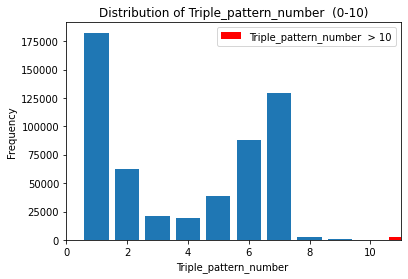

In [9]:
%pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV Data
data = pd.read_csv("unique_normalised_12_9_2023.csv")  # Replace with your actual CSV file path
complexity_column = data["triple_pattern_number"]

# Filter the data to include only values in the range [0, 10] and values > 10
filtered_complexity = complexity_column[(complexity_column >= 0) & (complexity_column <= 10)]

# Calculate Complexity Distribution for values in [0, 10]
complexity_distribution = filtered_complexity.value_counts().sort_index()

# Sum the frequencies of values > 10
total_frequency_above_10 = complexity_column[complexity_column > 10].sum()

# Create a Bar Plot
plt.bar(complexity_distribution.index, complexity_distribution.values)
plt.xlabel("Triple_pattern_number ")
plt.ylabel("Frequency")
plt.title("Distribution of Triple_pattern_number  (0-10)")

# Add a single bar for values > 10
plt.bar(11, total_frequency_above_10, color='red', label='Triple_pattern_number  > 10')

# Set x-axis limits to show all complexity values
plt.xlim(0, max(complexity_distribution.index) + 1)

# Add a legend
plt.legend()

plt.show()

## 4. We group similar queries and map them to a representative member



In [ ]:
pip install scikit-learn

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Read CSV file into a DataFrame
df = pd.read_csv('output.csv', lineterminator='\n', dtype=str)

# Use TF-IDF vectorizer to convert queries into numerical vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['query\r'])

# Perform K-Means clustering
num_clusters = 10  # You can adjust the number of clusters based on your data
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Find cluster centers
cluster_centers = kmeans.cluster_centers_

# Find the most representative query for each cluster
representative_queries = []
for cluster_center in cluster_centers:
    cluster_center = cluster_center.reshape(1, -1)
    similarity = cosine_similarity(cluster_center, X)
    most_similar_idx = similarity.argmax()
    representative_queries.append(df['query\r'][most_similar_idx])

# Print representative queries
for idx, query in enumerate(representative_queries, start=1):
    print(f"Cluster {idx} Representative Query: {query}")

print('done')

c:\Users\p70073484\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1 Representative Query: PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX schema: <http://schema.org/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

SELECT ?var11 ?var21 ?var301 ?var311 ?var321 ?var331 ?var431 ?var332 ?var432 ?var333WHERE {?var11 ?var21 <http://bio2rdf.org/go:0060071> . ?var11 ?var301 <http://bio2rdf.org/omim_vocabulary:Gene> . <http://bio2rdf.org/omim_vocabulary:Gene> ?var311 <http://bio2rdf.org/drugbank_vocabulary:target> . <http://bio2rdf.org/drugbank_vocabulary:target> ?var321 <http://bio2rdf.org/kegg_vocabulary:drug> . <http://bio2rdf.org/kegg_vocabulary:drug> ?var331 ?var431 . ?var431 ?var332 ?var432 . <htt

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Read CSV file into a DataFrame
df = pd.read_csv('output.csv', lineterminator='\n', dtype=str)

# Use TF-IDF vectorizer to convert queries into numerical vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['query\r'])

# Perform K-Means clustering
num_clusters = 10  # You can adjust the number of clusters based on your data
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Silhouette Score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Inertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Find cluster centers
cluster_centers = kmeans.cluster_centers_

# Find the most representative query for each cluster
representative_queries = []
for cluster_center in cluster_centers:
    cluster_center = cluster_center.reshape(1, -1)
    similarity = cosine_similarity(cluster_center, X)
    most_similar_idx = similarity.argmax()
    representative_queries.append(df['query\r'][most_similar_idx])

# Print representative queries
for idx, query in enumerate(representative_queries, start=1):
    print(f"Cluster {idx} Representative Query: {query}")

# Visual Inspection using PCA (for 2D visualization)
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X.toarray())

plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("PCA-based Clustering")
plt.show()

print('done')


c:\Users\p70073484\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.3218313243274922
Inertia: 108051.05829916647
Cluster 1 Representative Query: PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX schema: <http://schema.org/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

SELECT ?var11 ?var21 ?var301 ?var401 ?var402WHERE {?var11 ?var21 <http://bio2rdf.org/omim_vocabulary:Gene> . ?var301 ?var401 ?var11 . ?var301 ?var402 <http://bio2rdf.org/omim_resource:aa2721c8b2d3d6c5f3b040fa1a98ecc9> . FILTER (isIRI(?var11) && isIRI(?var301)) FILTER (?var11 != ?var301) FILTER (str(?var401) NOT IN ("http://rdfs.org/ns/void#inDataset", "http://bio2rdf.org/omim_vocabulary:refers-to", "http://bio2rdf.org/o

MemoryError: Unable to allocate 616. GiB for an array with shape (466519, 177226) and data type float64

## 7. We count subjects appearing in triple patterns of parsed queries, to calculate complexity

## To test calculate Informativness of one single query

In [ ]:
import json

text = '''
    {
      "queryType": "SELECT",
      "variables": "x y",
      "where": [
        {
          "type": "bgp",
          "triples": [
            {
              "subject": { "termType": "Variable", "value": "x" },
              "predicate": { "termType": "NamedNode", "value": "http://www.w3.org/1999/02/22-rdf-syntax-ns#type" },
              "object": { "termType": "Variable", "value": "y" }
            }
          ]
        },
        {
          "type": "group",
          "patterns": [
            {
              "queryType": "SELECT",
              "variables": [ { "termType": "Variable", "value": "y" } ],
              "where": [
                {
                  "type": "bgp",
                  "triples": [
                    {
                      "subject": { "termType": "Variable", "value": "y" },
                      "predicate": { "termType": "Variable", "value": "o" },
                      "object": { "termType": "Variable", "value": "d" }
                    }
                  ]
                }
              ],
              "type": "query"
            }
          ]
        }
      ],
      "type": "query",
      "prefixes": {}
    }
    '''

# Parse the JSON text into a Python dictionary
data = json.loads(text)

# Function to count variables and named nodes in the bgp section
def count_in_bgp(bgp_data):
    variable_count = 0
    named_node_count = 0

    if "triples" in bgp_data:
        triples = bgp_data["triples"]
        for triple in triples:
            if triple["subject"]["termType"] == "Variable":
                variable_count += 1
            elif triple["subject"]["termType"] == "NamedNode":
                named_node_count += 1
            if triple["predicate"]["termType"] == "Variable":
                variable_count += 1
            elif triple["predicate"]["termType"] == "NamedNode":
                named_node_count += 1
            if triple["object"]["termType"] == "Variable":
                variable_count += 1
            elif triple["object"]["termType"] == "NamedNode":
                named_node_count += 1

    return variable_count, named_node_count

# Initialize counts
total_variable_count = 0
total_named_node_count = 0

# Traverse through all "bgp" sections and count variables and named nodes in bgps
def traverse(data):
    global total_variable_count, total_named_node_count
    if isinstance(data, dict):
        if "type" in data and data["type"] == "bgp":
            variable_count, named_node_count = count_in_bgp(data)
            total_variable_count += variable_count
            total_named_node_count += named_node_count
        for key, value in data.items():
            traverse(value)
    elif isinstance(data, list):
        for item in data:
            traverse(item)

# Start traversing from the main JSON dictionary
traverse(data)

# Print the results
print("Total Variable Count:", total_variable_count)
print("Total Named Node Count:", total_named_node_count)


Total Variable Count: 5
Total Named Node Count: 1


## We calculate Informativness of all queries

In [3]:
import json
import csv

# Function to count variables and named nodes in the bgp section
def count_in_bgp(bgp_data):
    variable_count = 0
    named_node_count = 0

    if "triples" in bgp_data:
        triples = bgp_data["triples"]
        for triple in triples:
            subject_term_type = triple["subject"].get("termType", None)
            predicate_term_type = triple["predicate"].get("termType", None)
            object_term_type = triple["object"].get("termType", None)

            if subject_term_type == "Variable":
                variable_count += 1
            elif subject_term_type == "NamedNode":
                named_node_count += 1

            if predicate_term_type == "Variable":
                variable_count += 1
            elif predicate_term_type == "NamedNode":
                named_node_count += 1

            if object_term_type == "Variable":
                variable_count += 1
            elif object_term_type == "NamedNode":
                named_node_count += 1

    return variable_count, named_node_count

# Function to calculate informativeness and update CSV rows
def calculate_informativeness(input_file, output_file):
    with open(input_file, 'r', newline="\n", encoding="utf-8") as infile, open(output_file, 'w', newline="\n", encoding="utf-8") as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['Informativeness']
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            parsed_query = row['parsed_query']

            try:
                data = json.loads(parsed_query)
            except json.JSONDecodeError:
                print(f"Error parsing JSON in row: {row}")
                continue

            total_variable_count = 0
            total_named_node_count = 0

            # Traverse through all "bgp" sections and count variables and named nodes in bgps
            def traverse(data):
                nonlocal total_variable_count, total_named_node_count
                if isinstance(data, dict):
                    if "type" in data and data["type"] == "bgp":
                        variable_count, named_node_count = count_in_bgp(data)
                        total_variable_count += variable_count
                        total_named_node_count += named_node_count
                    for key, value in data.items():
                        traverse(value)
                elif isinstance(data, list):
                    for item in data:
                        traverse(item)

            # Start traversing from the main JSON dictionary
            traverse(data)

            # Update the row with informativeness values
            if total_variable_count + total_named_node_count == 0 or (total_variable_count == 0 and total_named_node_count == 0):
                informativeness = 0.0  # Default value when denominator is zero, 0/0
            else:
                informativeness = total_named_node_count / (total_variable_count + total_named_node_count)

            row['Informativeness'] = f'{informativeness}'
            writer.writerow(row)

# Provide the input and output file paths
input_csv_file = 'unique_normalised_12_9_2023.csv'
output_csv_file = 'bio2rdf-informativness.csv'

# Call the function to calculate informativeness and update the output CSV file
calculate_informativeness(input_csv_file, output_csv_file)

In [11]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('bio2rdf-informativness.csv', lineterminator='\n', dtype=str)

# Sort the DataFrame by "Informativeness" in descending order
df = df.sort_values(by='Informativeness\r', ascending=False)
pd.set_option('display.max_colwidth', None)  # Display full content of columns
# Print the complete sorted data
print(df)


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     query  \
245142  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX owl: <http://www.w3.org/2002/07/owl#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX dcterms: <http://purl.org/dc/terms/>\nPREFIX skos

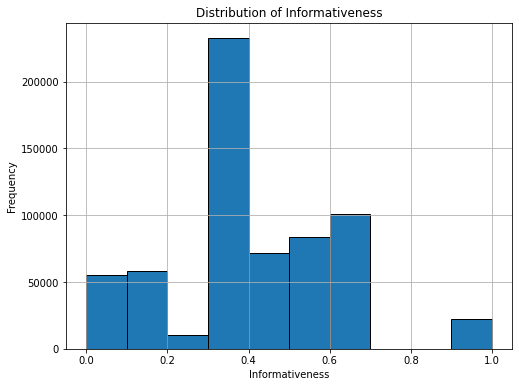

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file into a pandas DataFrame
csv_file = 'bio2rdf-informativness.csv'  # Replace with the path to your CSV file
df = pd.read_csv(csv_file)

# Step 2: Extract the "Informativeness" column
informativeness_column = df['Informativeness']

# Step 3: Create a histogram
plt.figure(figsize=(8, 6))  # Set the figure size (adjust as needed)
plt.hist(informativeness_column, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Informativeness')
plt.ylabel('Frequency')
plt.title('Distribution of Informativeness')
plt.grid(True)

# Step 4: Show the histogram or save it to a file
plt.show()  # To display the histogram
# Or you can save it to a file by using plt.savefig('informativeness_histogram.png')

# Optional: You can also customize the plot further, such as setting the colors, labels, and more.


In [ ]:
pip install seaborn matplotlib


In [26]:
import pandas as pd

# Read the CSV file into a DataFrame
csv_file_path = 'bio2rdf-informativness.csv'
df = pd.read_csv(csv_file_path)

# Sort the DataFrame based on the "Informativeness" column in descending order
sorted_df = df.sort_values(by='Informativeness', ascending=False)

# Save the sorted DataFrame to the original CSV file (overwriting the original)
sorted_df.to_csv(csv_file_path, index=False)

# Print the first five rows of the sorted DataFrame
print(sorted_df.head(3))
print(sorted_df.tail(3))


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          query  \
0                    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX owl: <http://www.w3.org/2002/07/owl#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX foaf: <ht

In [ ]:
import pandas as pd

# Read the input CSV file into a DataFrame
input_csv_file = 'bio2rdf-informativness.csv'
output_csv_file = 'queries_with_high_score.csv'
df = pd.read_csv(input_csv_file)

# Calculate the sum of "Informativeness" and "complexity" columns
df['Sum'] = df['Informativeness'] + df['complexity']

# Sort the DataFrame based on the "Sum" column in descending order
sorted_df = df.sort_values(by='Sum', ascending=False)

# Save the sorted DataFrame to the output CSV file
sorted_df.to_csv(output_csv_file, index=False)


In [ ]:
df= pd.read_csv('queries_with_high_score.csv')
print(df.head())

                                               Query  \
0  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
1  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
2  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
3  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
4  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   

                                        Parsed_Query  complexity  \
0  {"queryType":"SELECT","variables":[{}],"where"...          46   
1  {"queryType":"SELECT","distinct":true,"variabl...          37   
2  {"queryType":"SELECT","variables":[{}],"where"...          32   
3  {"queryType":"SELECT","distinct":true,"variabl...          32   
4  {"queryType":"CONSTRUCT","template":[{"subject...          30   

   Informativeness        Sum  
0         0.398551  46.398551  
1         0.180180  37.180180  
2         0.427083  32.427083  
3         0.156250  32.156250  
4         0.000000  30.000000  


## Instead of highest Informativness and highest complexity we find a best performing ratio for them.

In [ ]:
import pandas as pd

# Read the input CSV file into a DataFrame
input_csv_file = 'bio2rdf-informativness.csv'
output_csv_file = 'bio2rdf-selected_queries.csv'
df = pd.read_csv(input_csv_file)

# Filter the DataFrame based on specified conditions
filtered_df = df[(0.6 < df['Informativeness']) & (df['Informativeness'] < 0.80) & (2 < df['complexity']) & (df['complexity'] < 15)]

# Save the filtered DataFrame to the output CSV file
filtered_df.to_csv(output_csv_file, index=False)


In [ ]:
df= pd.read_csv('bio2rdf-selected_queries.csv')
print(df.head())

                                               Query  \
0  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
1  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
2  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
3  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   
4  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...   

                                        Parsed_Query  complexity  \
0  {"queryType":"SELECT","variables":[{}],"where"...           3   
1  {"queryType":"SELECT","variables":[{"termType"...           3   
2  {"queryType":"SELECT","variables":[{}],"where"...           5   
3  {"queryType":"SELECT","variables":[{}],"where"...           5   
4  {"queryType":"SELECT","variables":[{"termType"...           3   

   Informativeness  
0         0.777778  
1         0.777778  
2         0.666667  
3         0.666667  
4         0.666667  


## Caculate similarity

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(queries):
    # Create a TF-IDF vectorizer to convert queries into numerical vectors
    vectorizer = TfidfVectorizer()

    # Convert the list of queries to TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform(queries)

    # Calculate cosine similarity between all pairs of queries
    similarity_matrix = cosine_similarity(tfidf_matrix)

    return similarity_matrix

def main():
    # Read the CSV file into a Pandas DataFrame
    input_csv_file = "informativness.csv"  # Replace with the path to your CSV file
    output_csv_file = "queries_with_similarity.csv"  # Replace with the desired output CSV file

    df = pd.read_csv(input_csv_file)

    # Get the queries from the DataFrame
    queries = df['Query'].tolist()

    # Calculate similarity between queries
    similarity_matrix = calculate_similarity(queries)

    # Add the similarity values as a new column for each query
    similarity_column = []
    for i in range(len(queries)):
        similarity_column.append(similarity_matrix[i].tolist())

    df['similarity'] = similarity_column

    # Save the DataFrame with the new similarity column to a new CSV file
    df.to_csv(output_csv_file, index=False)

if __name__ == "__main__":
    main()


## Calculate uniqueness of Q(i)

We define it as average of the Jaccard similarity(or cosine) scores between the query and all other queries.

U(Q(n)) = (Σ J(Q(n), Q(i))) / |Q|

## Jacard similarity and tokenizer

In [ ]:
import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

# Step 1: Read the CSV file
csv_file_path = 'path_to_your_csv_file.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Tokenize the queries
tokenized_queries = [query.split() for query in df['sparql_query_column']]

# Step 3: Convert queries into sets
query_sets = [set(tokens) for tokens in tokenized_queries]

# Step 4: Calculate Jaccard similarity
jaccard_similarities = 1 - pairwise_distances(query_sets, metric='jaccard')

# Step 5: Calculate the average uniqueness score for each query
average_uniqueness_scores = jaccard_similarities.mean(axis=1)

# Now 'average_uniqueness_scores' contains a single value representing the uniqueness of each query.


## Cosine similarity and vectores 

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

# Step 1: Read the CSV file
csv_file_path = 'path_to_your_csv_file.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Convert queries into a list of strings
query_list = df['sparql_query_column'].tolist()

# Step 3: Calculate Cosine similarity
vectorizer = CountVectorizer()
query_vectors = vectorizer.fit_transform(query_list)
cosine_similarities = 1 - pairwise_distances(query_vectors, metric='cosine')

# Step 4: Calculate the average uniqueness score for each query
average_uniqueness_scores = cosine_similarities.mean(axis=1)

# Now 'average_uniqueness_scores' contains a single value representing the uniqueness of each query.


##  Optimized

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Read the CSV file
csv_file_path = 'path_to_your_csv_file.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Define the batch size for processing
batch_size = 1000

# Step 3: Initialize the vectorizer
vectorizer = TfidfVectorizer(use_idf=False)

# Step 4: Initialize the variable to store the final results
result_uniqueness_scores = []

# Step 5: Process data in batches
for i in range(0, len(df), batch_size):
    batch_queries = df['sparql_query_column'].iloc[i:i + batch_size].tolist()
    # Convert the queries into a sparse matrix
    batch_query_vectors = vectorizer.transform(batch_queries)
    # Calculate cosine similarity for the batch
    cosine_similarities = cosine_similarity(batch_query_vectors)
    # Compute the average uniqueness score for each query in the batch
    average_uniqueness_scores = cosine_similarities.mean(axis=1)
    result_uniqueness_scores.extend(average_uniqueness_scores)

# Now 'result_uniqueness_scores' contains a list of values representing the uniqueness of each query.


## Execute queries:

In [ ]:
%pip install SPARQLWrapper

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON, SPARQLExceptions

# Define the SPARQL endpoint URL
sparql_endpoint = "https://bio2rdf.org/sparql"

# Your SPARQL query
sparql_query = """
select ?s where {?s a ?o} limit 10
"""

# Create a SPARQLWrapper instance and set the endpoint URL
sparql = SPARQLWrapper(sparql_endpoint)

# Set the SPARQL query
sparql.setQuery(sparql_query)

# Set the return format to JSON
sparql.setReturnFormat(JSON)

try:
    # Execute the query and fetch the results
    results = sparql.query().convert()

    # Process the results
    if "results" in results and "bindings" in results["results"]:
        bindings = results["results"]["bindings"]
        count = len(bindings)
        print("Total count:", count)
    else:
        print("No results found in the query response.")

except SPARQLExceptions.QueryBadFormed as e:
    print("Query syntax error:", e)
except SPARQLExceptions.EndPointInternalError as e:
    print("Endpoint internal error:", e)
except Exception as e:
    print("An error occurred:", e)


In [ ]:
import csv
from SPARQLWrapper import SPARQLWrapper, JSON

# Define the SPARQL endpoint URL
sparql_endpoint = "https://bio2rdf.org/sparql"

# Path to your CSV file
csv_file_path = "all_colchain-interlinkness.csv"
output_csv_file_path = "interlinkness_queries.csv"

# Initialize a counter for matching queries
matching_count = 0

# Open the input CSV file
with open(csv_file_path, "r") as file:
    csv_reader = csv.DictReader(file)

    # Open the output CSV file to write matching queries
    with open(output_csv_file_path, "w", newline="") as output_file:
        output_writer = csv.writer(output_file)
        output_writer.writerow(["Query"])

        # Assuming "Query" is the name of the column
        for row in csv_reader:
            query = row["Query"]

            # Create a SPARQLWrapper instance and set the endpoint URL
            sparql = SPARQLWrapper(sparql_endpoint)

            # Set the SPARQL query
            sparql.setQuery(query)

            # Set the return format to JSON
            sparql.setReturnFormat(JSON)

            try:
                # Execute the query and fetch the results
                results = sparql.query().convert()

                # Process the results
                if "results" in results and "bindings" in results["results"]:
                    total_count = len(results["results"]["bindings"])
                    if total_count > 0:
                        print(f"Matching query with Total count > 0: {query}")
                        output_writer.writerow([query])
                        matching_count += 1

                    # Stop process if 10 matching queries are found
                    if matching_count >= 10:
                        break

                else:
                    print(f"No results found for query: {query}")

            except Exception as e:
                print(f"An error occurred for query: {query}", e)

print("Process completed.")
